In [1]:
import pyopencl as cl
import xopto

print(f"Successfully imported xopto version: {xopto.__version__}")

print("\n--- Verifying PyOpenCL Installation ---")
platforms = cl.get_platforms()
if not platforms:
    print("!!! ERROR: No OpenCL platforms found. Check Intel OpenCL runtime installation.")
else:
    print(f"Found {len(platforms)} OpenCL platform(s).")
    for i, platform in enumerate(platforms):
        print(f"\n--- Platform {i}: {platform.name} ---")
        devices = platform.get_devices()
        if not devices:
            print("  No devices found on this platform.")
        else:
            print(f"  Found {len(devices)} device(s).")
            for j, device in enumerate(devices):
                print(f"    Device {j}: {device.name}")
                print(f"      Type: {cl.device_type.to_string(device.type)}")
                print(f"      Max Compute Units: {device.max_compute_units}")

Successfully imported xopto version: 0.2.3

--- Verifying PyOpenCL Installation ---
Found 2 OpenCL platform(s).

--- Platform 0: Intel(R) OpenCL Graphics ---
  Found 1 device(s).
    Device 0: Intel(R) Iris(R) Xe Graphics
      Type: ALL | GPU
      Max Compute Units: 96

--- Platform 1: Portable Computing Language ---
  Found 1 device(s).
    Device 0: cpu-haswell-13th Gen Intel(R) Core(TM) i9-13900H
      Type: ALL | CPU
      Max Compute Units: 20


In [3]:
from xopto.mcml import mc
from xopto.materials import skin
from xopto.util import color
from xopto.materials import ri

import numpy as np
from matplotlib import pyplot as pp

/home/mikhail/Projects/Skoltech/Biophotonics/light-in-skin-animation/pyxopto/xopto/materials/absorption/base.py:137: UserWarning: Wavelength is out of valid range [100.0, 799.5] nm!
  warnings.warn(


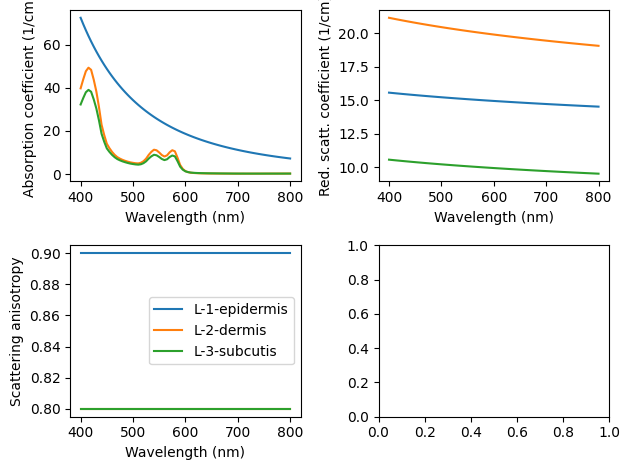

In [15]:
# creating a default 3-layer skin model
model = skin.Skin3()

# using the skin model to create the layer stack (5 MC layers, i.e. the first
# and the last layer in the stack represent the surrounding medium)
layers = model.create_mc_layers(550e-9)

# # customization of the skin model
# model[0].n = ri.skin.default
# model[0].d = 0.100e-3
# model[0].melanin = 0.02
# model[0].baseline_absorption = 0.0
# model[1].d = 1.5e-3
# model[1].blood = 0.005
# model[1].spo2 = 0.97
# model[1].baseline_absorption = 0.0
# model[2].blood = 0.01
# model[2].spo2 = 0.97
# model[2].baseline_absorption = 0.0

# plot the skin model
model.plot()

In [16]:
# creating the source of photon packets
incidence_angle = np.deg2rad(45.0) # 0 deg for perpendicular incidence
source = mc.mcsource.Line(
    direction=[np.sin(incidence_angle), 0.0, np.cos(incidence_angle)])

In [17]:
# RGB color space and observer selection
RGB = color.cie.SRGB
#observer = color.cie.CIE1931 # 2 deg field of view
observer = color.cie.CIE1964 # 10 deg field of view
observer_cosmin = np.cos(observer.fov/2)

In [18]:
# creating total reflectance surface detector
detectors = mc.mcdetector.Detectors(
    top=mc.mcdetector.Total(cosmin=observer_cosmin),
    specular=mc.mcdetector.Total(cosmin=observer_cosmin)
)
# include specular component in color computation
with_specular = False

In [19]:
# selecting the first available OpenCL GPU device
gpu = mc.clinfo.gpu()

# creating a Monte Carlo simulator instance
mc_obj = mc.Mc(layers, source, detectors, cl_devices=gpu)
mc_obj.rmax = 50.0e-3

# standard wavelength range with a 10 nm spectral resolution
wavelengths = color.cie.STANDARD_WAVELENGTHS_10_NM

In [29]:
# running MC simulations for each wavelength
reflectance = np.zeros_like(wavelengths)
for index, wavelength in enumerate(wavelengths):
    print('Processing wavelength {:d}/{:<10d}'.format(
        index + 1, wavelengths.size), end='\r')
    # update the MC layers with the skin model
    model.update_mc_layers(mc_obj.layers, wavelength)
    # running the MC simulation with 1,000,000 photon packets
    _, _, detectors_res = mc_obj.run(1e6)
    # extract reflectance
    r = detectors_res.top.reflectance
    if with_specular: # include specular component if required
        r += detectors_res.specular.reflectance
    # using RGB color space illuminant spectral power density
    reflectance[index] = r*RGB.illuminant.spd(wavelength)

/tmp/ipykernel_190867/1936301694.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reflectance[index] = r*RGB.illuminant.spd(wavelength)


In [30]:
print()
k = RGB.autoexposure(wavelengths, reflectance, observer, 1.0)
k = 0.006999074230406075
# compute color, correct illuminant luminosity for Lambertian reflector and
# solid acceptance angle of the CIE observer
rgb = RGB.from_spectrum(wavelengths, reflectance,
                        observer=observer,
                        normalize=k)
rgb_uint8 = np.round(np.clip(rgb, 0.0, 1.0)*255).astype(np.uint8)
print('Raw normalized RGB components:', rgb)


Raw normalized RGB components: [0.5373633  0.26441857 0.15623413]


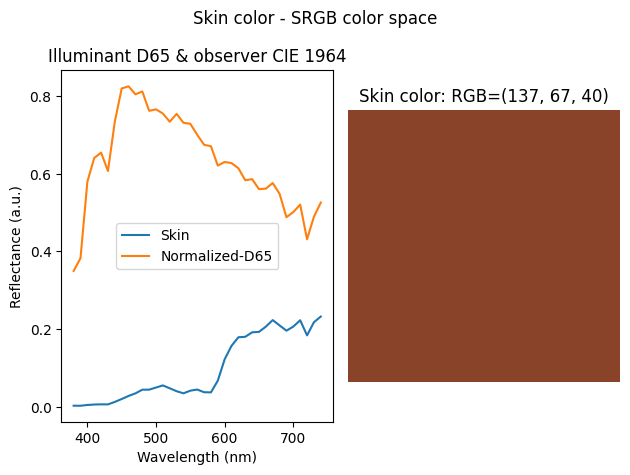

In [31]:
fig, ax = pp.subplots(1, 2)
pp.suptitle('Skin color - {} color space'.format(RGB.name))
ax[0].plot(wavelengths*1e9, reflectance, label='Skin') #(1.0 - observer_cosmin)
ax[0].plot(wavelengths*1e9,
            RGB.illuminant.spd(wavelengths)*k,
            label='Normalized-{}'.format(RGB.illuminant.name))
ax[0].set_xlabel('Wavelength (nm)')
ax[0].set_ylabel('Reflectance (a.u.)')
ax[0].set_title('Illuminant {:s} & observer {:s}'.format(
    RGB.illuminant.name, observer.name))
ax[0].legend()

ax[1].imshow(np.reshape(rgb_uint8, [1, 1, 3]))
ax[1].set_title('Skin color: RGB=({:d}, {:d}, {:d})'.format(*rgb_uint8))
ax[1].set_axis_off()
pp.tight_layout()
pp.show()

array([0.00325331, 0.0031283 , 0.00513866, 0.00626758, 0.00673778,
       0.00663415, 0.01298557, 0.02043445, 0.02831034, 0.03497996,
       0.04434913, 0.04454507, 0.04999812, 0.05538767, 0.04796862,
       0.0404962 , 0.03512368, 0.04192655, 0.0448238 , 0.03788686,
       0.03752348, 0.06765791, 0.12259403, 0.15732579, 0.1792515 ,
       0.18043866, 0.19195722, 0.19314102, 0.20663574, 0.22340614,
       0.20969577, 0.19614688, 0.20674982, 0.22298531, 0.18411122,
       0.21789552, 0.23246895])